# Results for the selection using multi-slim 

The results are based on the specialists evolution capabilities and not on the multi-slim capabilities themselves. This study only shows how selectors influence the ability of GP to evolve a population with good specialists, *which may not translate into multi-slim capabilities*. 

In [1]:
from collections import defaultdict
from itertools import chain
import os 
import numpy as np 
import pandas as pd 
import pickle 
import matplotlib.pyplot as plt
from ace_tools_open import display_dataframe_to_user

______________________________________________________

### Statistical tests for DALEX vs DALEX-SIZE-2 

In [140]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from collections import defaultdict

data_dir = 'selector_experiments'

def p_value_to_stars(p_value):
    if p_value is None or np.isnan(p_value):
        return ''
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'nsd'

file_metrics = []

if os.path.isdir(data_dir):
    for fname in os.listdir(data_dir):
        if not fname.endswith('.pkl'):
            continue

        base = fname[:-4]
        parts = base.split('_')

        if len(parts) < 5:
            continue

        dataset = parts[0]
        selector = '_'.join(parts[4:])

        if not selector:
             continue
        
        if selector not in ['dalex', 'dalex_size_2']:
            continue
        
        file_id = fname 

        with open(os.path.join(data_dir, fname), 'rb') as f:
            logs = pickle.load(f)

        if not logs: continue
        if isinstance(logs, dict): logs = [logs]
        if not isinstance(logs, list) or not all(isinstance(entry, dict) for entry in logs): continue

        required_keys = ['result', 'size']
        valid_logs = []
        for entry in logs:
            if all(key in entry for key in required_keys) and \
               isinstance(entry['result'], (np.ndarray, list)) and len(entry['result']) > 0 and \
               isinstance(entry['size'], (np.ndarray, list)) and len(entry['size']) > 0:
                valid_logs.append(entry)
        
        if not valid_logs: continue
        
        all_rmse = np.vstack([entry['result'] for entry in valid_logs])
        all_size = np.vstack([entry['size'] for entry in valid_logs])

        run_rmse_norms = np.linalg.norm(all_rmse, axis=1)
        run_size_norms = np.linalg.norm(all_size, axis=1)

        if run_rmse_norms.size > 0 and run_size_norms.size > 0:
            file_metrics.append({
                'dataset': dataset,
                'selector': selector,
                'file_id': file_id,
                'med_rmse_norm': np.median(run_rmse_norms),
                'rmse_norm_runs': run_rmse_norms,
                'med_size_norm': np.median(run_size_norms),
                'size_norm_runs': run_size_norms,
            })

all_metrics_df = pd.DataFrame(file_metrics)
stats_df = pd.DataFrame() 

if not all_metrics_df.empty:
    best_indices = all_metrics_df.groupby(['dataset', 'selector'])['med_rmse_norm'].idxmin()
    best_settings_df = all_metrics_df.loc[best_indices].copy()

    results_list = []
    if not best_settings_df.empty:
        unique_datasets = sorted(best_settings_df['dataset'].unique())

        for ds_name in unique_datasets:
            dalex_best_data = best_settings_df[
                (best_settings_df['dataset'] == ds_name) &
                (best_settings_df['selector'] == 'dalex')
            ]
            dalex_s2_best_data = best_settings_df[
                (best_settings_df['dataset'] == ds_name) &
                (best_settings_df['selector'] == 'dalex_size_2')
            ]

            row = {
                'dataset': ds_name,
                'med_rmse_d': np.nan, 'med_rmse_d2': np.nan, 'p_val_rmse': np.nan, 'rmse_stars': '',
                'med_size_d': np.nan, 'med_size_d2': np.nan, 'p_val_size': np.nan, 'size_stars': '',
            }

            if not dalex_best_data.empty and not dalex_s2_best_data.empty:
                dalex_rmse_r = dalex_best_data.iloc[0]['rmse_norm_runs']
                dalex_s2_rmse_r = dalex_s2_best_data.iloc[0]['rmse_norm_runs']
                
                row['med_rmse_d'] = np.median(dalex_rmse_r)
                row['med_rmse_d2'] = np.median(dalex_s2_rmse_r)

                if len(dalex_rmse_r) > 0 and len(dalex_s2_rmse_r) > 0 :
                        _, p_val_rmse = mannwhitneyu(dalex_rmse_r, dalex_s2_rmse_r, alternative='less', nan_policy='propagate')
                        row['p_val_rmse'] = p_val_rmse
                        row['rmse_stars'] = p_value_to_stars(p_val_rmse)

                dalex_size_r = dalex_best_data.iloc[0]['size_norm_runs']
                dalex_s2_size_r = dalex_s2_best_data.iloc[0]['size_norm_runs']

                row['med_size_d'] = np.median(dalex_size_r)
                row['med_size_d2'] = np.median(dalex_s2_size_r)

                if len(dalex_size_r) > 0 and len(dalex_s2_size_r) > 0:
                    _, p_val_size = mannwhitneyu(dalex_size_r, dalex_s2_size_r, alternative='less', nan_policy='propagate')
                    row['p_val_size'] = p_val_size
                    row['size_stars'] = p_value_to_stars(p_val_size)
            
            results_list.append(row)

        stats_df = pd.DataFrame(results_list)
        if not stats_df.empty:
            stats_df.set_index('dataset', inplace=True)
            
            # Define desired column order
            column_order = [
                'med_rmse_d', 'med_rmse_d2', 'p_val_rmse', 'rmse_stars',
                'med_size_d', 'med_size_d2', 'p_val_size', 'size_stars'
            ]
            # Filter to only include columns that actually exist in stats_df
            existing_cols_in_order = [col for col in column_order if col in stats_df.columns]
            stats_df = stats_df[existing_cols_in_order]

stats_df

,med_rmse_d,med_rmse_d2,p_val_rmse,rmse_stars,med_size_d,med_size_d2,p_val_size,size_stars
dataset,,,,,,,,
synthetic10,184.701209,178.410405,2.505718e-01,nsd,197.641588,70.816789,1.000000,nsd
synthetic2,0.196417,0.232456,1.777362e-01,nsd,45.842104,28.381265,1.000000,nsd
synthetic3,0.951131,1.328205,6.105970e-03,**,56.469888,33.984972,1.000000,nsd
synthetic4,0.008552,0.008516,3.530857e-01,nsd,53.065983,36.742306,0.999997,nsd
synthetic5,0.006937,0.000804,6.931280e-01,nsd,17.823726,11.401754,0.982047,nsd
synthetic6,11.246357,10.825118,8.709743e-01,nsd,62.776761,42.868689,0.999982,nsd
synthetic7,0.133209,0.138344,3.176633e-02,*,64.365806,35.019529,1.000000,nsd
synthetic8,5.040192,6.125168,1.139012e-05,***,117.462712,37.041950,1.000000,nsd
synthetic9,0.270084,0.804942,4.531603e-08,***,75.299716,26.178116,1.000000,nsd


### Metrics by dataset and selector

In [141]:
data_dir = 'selector_experiments' 
dataset_selection = 'synthetic8'

records = []
for fname in os.listdir(data_dir):
    if not fname.endswith('.pkl'):
        continue
    # parse metadata
    base = fname[:-4]
    parts = base.split('_')
    dataset = parts[0]
    if dataset != dataset_selection:
        continue
    n_iter   = int(parts[1])
    pop_size = int(parts[2])
    pp       = None if parts[3]=='None' else int(parts[3])
    selector = '_'.join(parts[4:])
    
    # load logs
    with open(os.path.join(data_dir, fname), 'rb') as f:
        logs = pickle.load(f)
    if isinstance(logs, dict):
        logs = [logs]
    
    # stack arrays: shape (runs, specialists)
    all_rmse = np.vstack([entry['result'] for entry in logs])
    all_size = np.vstack([entry['size']   for entry in logs])
    all_dur  = np.hstack([entry['duration'] for entry in logs])
    
    # per-run metrics
    run_rmse_norms = np.linalg.norm(all_rmse, axis=1)
    
    # summary record
    rec = {
        'dataset':           dataset,
        'selector':          selector,
        'n_iter':            n_iter,
        'pop_size':          pop_size,
        'pp':                pp,
        'duration_mean':     np.mean(all_dur),
        'rmse_norm_med':  np.median(run_rmse_norms),
        'rmse_norm_mean':    np.mean(run_rmse_norms),
        'mean_size':         np.mean(all_size),
    }
    
    # per-specialist mean ± std
    spec_count = all_rmse.shape[1]
    for instrument, all_data in zip(['rmse', 'size'], [all_rmse, all_size]):
        for i in range(spec_count):
            rec[f'{instrument}_spec{i+1}_mean'] = f'{np.mean(all_data[:, i]):.2f} ± {np.std(all_data[:, i]):.2f}'
    
    records.append(rec)

# Build DataFrame
df_summary = pd.DataFrame(records)

# Display to user
display_dataframe_to_user("Detailed Specialist Metrics Summary", df_summary)

Detailed Specialist Metrics Summary


### DALEX vs DALEX-SIZE-2 dataset

In [147]:
data_dir = 'selector_experiments'
records = []

if not os.path.isdir(data_dir):
    print(f"Error: Directory '{data_dir}' not found.")
else:
    for fname in os.listdir(data_dir):
        if not fname.endswith('.pkl'):
            continue
        base = fname[:-4]
        parts = base.split('_')

        if len(parts) < 5:
            print(f"Skipping file with unexpected name format: {fname}")
            continue

        dataset = parts[0]
        try:
            n_iter = int(parts[1])
            pop_size = int(parts[2])
            pp_str = parts[3]
            pp = None if pp_str.lower() == 'none' else int(pp_str)
        except ValueError:
            print(f"Skipping file due to parsing error in numeric parts: {fname}")
            continue
            
        selector = '_'.join(parts[4:])
        if not selector: # Ensure selector is not empty if filename ends with _
             print(f"Skipping file with empty selector: {fname}")
             continue

        try:
            with open(os.path.join(data_dir, fname), 'rb') as f:
                logs = pickle.load(f)
        except Exception as e:
            print(f"Error loading pickle file {fname}: {e}")
            continue

        if not logs:
            print(f"Warning: Empty logs in file {fname}. Skipping.")
            continue
            
        if isinstance(logs, dict): # Handle cases where a single log entry might not be in a list
            logs = [logs]
        
        if not isinstance(logs, list) or not all(isinstance(entry, dict) for entry in logs):
            print(f"Warning: Logs in {fname} are not in the expected list of dicts format. Skipping.")
            continue

        required_keys = ['result', 'size', 'duration']
        valid_logs = []
        for entry_idx, entry in enumerate(logs):
            if all(key in entry for key in required_keys):
                valid_logs.append(entry)
            else:
                missing = [key for key in required_keys if key not in entry]
                print(f"Warning: Log entry {entry_idx} in {fname} is missing keys: {missing}. Skipping entry.")
        
        if not valid_logs:
            print(f"Warning: No valid log entries found in {fname} after key check. Skipping file.")
            continue
        logs = valid_logs

        try:
            all_rmse = np.vstack([entry['result'] for entry in logs])
            all_size = np.vstack([entry['size'] for entry in logs])
            all_dur = np.array([entry['duration'] for entry in logs])
            if all_dur.ndim == 2 and all_dur.shape[1] == 1 : # If it became [[d1], [d2]]
                all_dur = all_dur.flatten()
            elif all_dur.ndim > 1: 
                if all_dur.shape[1] > 0 :
                     all_dur = np.mean(all_dur, axis=1)
                else: # If shape is (N,0) or similar
                    print(f"Warning: Cannot process 'duration' for {fname}, shape {all_dur.shape}. Using NaN.")
                    all_dur = np.full(len(logs), np.nan)


            # Per-run metrics (L2 norm across specialists for each run)
            run_rmse_norms = np.linalg.norm(all_rmse, axis=1)
        except Exception as e:
            print(f"Error processing numpy arrays for {fname}: {e}. Skipping file.")
            continue
        
        # Summary record for this file
        rec = {
            'dataset': dataset,
            'selector': selector,
            'n_iter': n_iter,
            'pop_size': pop_size,
            'pp': pp,
            'num_runs': len(logs), # Number of experimental runs in this file
            'duration_mean': np.mean(all_dur) if all_dur.size > 0 else np.nan,
            'duration_median': np.median(all_dur) if all_dur.size > 0 else np.nan,
            'duration_std': np.std(all_dur) if all_dur.size > 0 else np.nan,
            'rmse_norm_median': np.median(run_rmse_norms) if run_rmse_norms.size > 0 else np.nan,
            'rmse_norm_mean': np.mean(run_rmse_norms) if run_rmse_norms.size > 0 else np.nan,
            'rmse_norm_std': np.std(run_rmse_norms) if run_rmse_norms.size > 0 else np.nan,
            'rmse_median' : np.median(all_rmse) if all_rmse.size > 0 else np.nan,
            'size_mean' : np.mean(all_size) if all_size.size > 0 else np.nan,
            'size_median' : np.median(all_size) if all_size.size > 0 else np.nan,
            'size_std' : np.std(all_size) if all_size.size > 0 else np.nan,
        }

        if all_rmse.size > 0 :
            spec_count = all_rmse.shape[1]
            for instrument, all_data in zip(['rmse', 'size'], [all_rmse, all_size]):
                for i in range(spec_count):
                    # Storing mean and std separately for easier aggregation later
                    rec[f'{instrument}_spec{i+1}_mean'] = np.mean(all_data[:, i])
                    rec[f'{instrument}_spec{i+1}_std'] = np.std(all_data[:, i])
        else:
            print(f"Warning: 'all_rmse' is empty for {fname}. Skipping specialist metrics.")


        records.append(rec)

if not records:
    print("No records were processed. Exiting.")
else:
    df_master_summary = pd.DataFrame(records)
    # display_dataframe_to_user("Master Summary of All Experiments", df_master_summary) # If in Jupyter/IPython
    
    agg_metrics = {
        'num_runs': 'sum',
        'duration_mean': 'mean',
        'duration_median': 'median',
        'rmse_norm_mean': 'mean',
        'rmse_norm_median': 'median',
        'rmse_norm_std': 'mean',
        'rmse_median' : 'median',
        'size_mean': 'mean',
        'size_median': 'median',
        'size_std': 'mean',
        'dataset': pd.Series.nunique 
    }
    
    df_selector_performance = df_master_summary.groupby('selector').agg(agg_metrics).sort_values(by='rmse_norm_median')

    agg_metrics_ds_sel = {
        'num_runs': 'sum',
        'duration_median': 'median',
        'rmse_norm_median': 'median', # Use median as it's often more robust for performance
        'size_median': 'median',
    }
    # for col in df_master_summary.columns:
    #     if '_spec' in col and '_mean' in col:
    #         agg_metrics_ds_sel[col] = 'mean'

    df_dataset_selector_performance = df_master_summary.groupby(['dataset', 'selector']).agg(agg_metrics_ds_sel).sort_values(by=['dataset', 'rmse_norm_median'])


selectors_to_filter = ['dalex', 'dalex_size_2']

mask = df_dataset_selector_performance.index.get_level_values('selector').isin(selectors_to_filter)
df_filtered_selectors = df_dataset_selector_performance[mask]

display_dataframe_to_user("Filtered Dataset-Selector Performance", df_filtered_selectors[['rmse_norm_median', 'size_median']])

Filtered Dataset-Selector Performance


In [71]:
idx_of_best_rows = df_master_summary.groupby(['dataset', 'selector'])['rmse_norm_median'].idxmin()
df_best_per_group = df_master_summary.loc[idx_of_best_rows]
df_best_per_group_sorted = df_best_per_group.sort_values(by=['dataset', 'selector'])
df_best_per_group_sorted = df_best_per_group_sorted[['dataset', 'selector', 'n_iter', 'pop_size', 'pp', 
                                                     'rmse_norm_median', 'rmse_median', 
                                                     'duration_mean', 'size_median']]

df_best_per_group_sorted

,dataset,selector,n_iter,pop_size,pp,rmse_norm_median,rmse_median,duration_mean,size_median
42,synthetic10,dalex,400,200,10.0,184.701209,4.718990e+01,50.039670,81.5
17,synthetic10,dalex_size,100,500,10.0,208.080224,3.731870e+01,16.058072,15.0
21,synthetic10,dalex_size_2,100,500,20.0,178.410405,4.216791e+01,18.593778,27.0
51,synthetic10,tournament,400,200,NaN,530.658863,6.830661e+01,33.976648,84.0
68,synthetic2,dalex,100,500,10.0,0.196417,5.236568e-02,18.270604,32.0
72,synthetic2,dalex_size,100,500,20.0,0.365775,1.133222e-16,15.067828,7.0
70,synthetic2,dalex_size_2,100,500,10.0,0.232456,6.164326e-02,16.933573,21.0
64,synthetic2,tournament,1000,100,NaN,0.408590,2.587599e-01,27.463209,43.0
146,synthetic3,dalex,400,200,10.0,0.951131,2.387422e-01,30.251031,40.5
121,synthetic3,dalex_size,100,500,10.0,1.600386,5.403753e-01,15.785310,13.0


In [ ]:
idx_of_best_rows = df_master_summary.groupby(['dataset', 'selector'])['rmse_norm_median'].idxmin()
df_best_per_group = df_master_summary.loc[idx_of_best_rows]
df_best_per_group_sorted = df_best_per_group.sort_values(by=['dataset', 'selector'])

columns_to_select = ['dataset', 'selector', 'n_iter', 'pop_size', 'pp',
                        'rmse_norm_median', 'rmse_median',
                        'duration_mean', 'size_median']

existing_columns = [col for col in columns_to_select if col in df_best_per_group_sorted.columns]
df_best_per_group_sorted = df_best_per_group_sorted[existing_columns]

df_dalex_baseline = df_best_per_group_sorted[df_best_per_group_sorted['selector'] == 'dalex'].copy()
df_dalex_baseline = df_dalex_baseline[['dataset', 'rmse_norm_median']]
df_dalex_baseline.rename(columns={'rmse_norm_median': 'dalex_rmse_baseline'}, inplace=True)

df_with_baseline = pd.merge(df_best_per_group_sorted, df_dalex_baseline, on='dataset', how='left')

df_with_baseline['rmse_ratio_to_dalex'] = df_with_baseline['rmse_norm_median'] / df_with_baseline['dalex_rmse_baseline']
df_with_baseline['size_ratio_to_dalex'] = df_with_baseline['size_median'] / df_with_baseline['dalex_size_baseline']

df_with_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

In [96]:
# 1. Get the best rmse_norm_median for each dataset and selector
if not df_master_summary.empty:
    try:
        # Find the index of the row with the minimum 'rmse_norm_median' for each group
        idx_of_best_rows = df_master_summary.groupby(['dataset', 'selector'])['rmse_norm_median'].idxmin()
        # Select these rows from the original DataFrame
        df_best_per_group = df_master_summary.loc[idx_of_best_rows]
    except KeyError as e:
        # This can happen if a group consists entirely of NaNs for 'rmse_norm_median'
        print(f"KeyError during groupby or idxmin: {e}. This might happen if a group has all NaN for 'rmse_norm_median'.")
        print("Using dropna() before idxmin as a workaround for such cases.")
        idx_of_best_rows = df_master_summary.dropna(subset=['rmse_norm_median']).groupby(['dataset', 'selector'])['rmse_norm_median'].idxmin()
        df_best_per_group = df_master_summary.loc[idx_of_best_rows]

    # Sort the resulting DataFrame for better readability
    df_best_per_group_sorted = df_best_per_group.sort_values(by=['dataset', 'selector'])

    # Define the columns to select based on user's latest specification
    columns_to_select = ['dataset', 'selector', 'n_iter', 'pop_size', 'pp',
                         'rmse_norm_median', 'rmse_median',
                         'duration_mean', 'size_median']

    # Ensure only existing columns are selected to avoid KeyErrors
    existing_columns = [col for col in columns_to_select if col in df_best_per_group_sorted.columns]
    if len(existing_columns) != len(columns_to_select):
        missing_cols = set(columns_to_select) - set(existing_columns)
        print(f"Warning: The following columns were not found in df_best_per_group_sorted and will be excluded: {missing_cols}")
    df_best_per_group_sorted = df_best_per_group_sorted[existing_columns]

    print("--- DataFrame with best RMSE per group (df_best_per_group_sorted) ---")
    print(df_best_per_group_sorted.head())

    # 2. Isolate the 'dalex' selector's metrics for baseline
    df_dalex_baseline_metrics = df_best_per_group_sorted[df_best_per_group_sorted['selector'] == 'dalex'].copy()
    
    required_baseline_cols = ['dataset', 'rmse_norm_median']
    rename_map = {'rmse_norm_median': 'dalex_rmse_baseline'}

    if 'size_median' in df_dalex_baseline_metrics.columns:
        required_baseline_cols.append('size_median')
        rename_map['size_median'] = 'dalex_size_baseline'
    else:
        print("Warning: 'size_median' column not found in 'dalex' baseline data. Size ratio cannot be calculated.")

    if 'duration_mean' in df_dalex_baseline_metrics.columns:
        required_baseline_cols.append('duration_mean')
        rename_map['duration_mean'] = 'dalex_duration_baseline'
    else:
        print("Warning: 'duration_mean' column not found in 'dalex' baseline data. Duration ratio cannot be calculated.")

    df_dalex_baseline = df_dalex_baseline_metrics[required_baseline_cols]
    df_dalex_baseline.rename(columns=rename_map, inplace=True)

    print("\n--- Dalex Baseline Metrics (RMSE, Size, Duration) ---")
    print(df_dalex_baseline.head())

    # 3. Merge the baseline back to the main DataFrame
    df_with_baseline = pd.merge(df_best_per_group_sorted, df_dalex_baseline, on='dataset', how='left')

    print("\n--- DataFrame with Dalex Baselines Merged ---")
    print(df_with_baseline.head())

    # 4. Calculate the ratios
    # RMSE Ratio
    if 'dalex_rmse_baseline' in df_with_baseline.columns and 'rmse_norm_median' in df_with_baseline.columns:
        df_with_baseline['rmse_ratio_to_dalex'] = df_with_baseline['rmse_norm_median'] / df_with_baseline['dalex_rmse_baseline']
    else:
        print("Warning: Could not calculate 'rmse_ratio_to_dalex' due to missing columns ('rmse_norm_median' or 'dalex_rmse_baseline').")

    # Size Ratio
    if 'dalex_size_baseline' in df_with_baseline.columns and 'size_median' in df_with_baseline.columns:
        df_with_baseline['size_ratio_to_dalex'] = df_with_baseline['size_median'] / df_with_baseline['dalex_size_baseline']
    else:
        print("Warning: Could not calculate 'size_ratio_to_dalex' due to missing columns ('size_median' or 'dalex_size_baseline').")
        
    # Duration Ratio
    if 'dalex_duration_baseline' in df_with_baseline.columns and 'duration_mean' in df_with_baseline.columns:
        df_with_baseline['duration_ratio_to_dalex'] = df_with_baseline['duration_mean'] / df_with_baseline['dalex_duration_baseline']
    else:
        print("Warning: Could not calculate 'duration_ratio_to_dalex' due to missing columns ('duration_mean' or 'dalex_duration_baseline').")

    # Handle potential division by zero or NaN results from ratio calculations
    df_with_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

    print("\n--- Final DataFrame with RMSE, Size, and Duration Ratios to Dalex ---")
    print(df_with_baseline)

    # Display specific columns for clarity
    key_ratio_columns = ['dataset', 'selector', 'rmse_norm_median', 'size_median', 'duration_mean']
    if 'dalex_rmse_baseline' in df_with_baseline.columns: key_ratio_columns.append('dalex_rmse_baseline')
    if 'rmse_ratio_to_dalex' in df_with_baseline.columns: key_ratio_columns.append('rmse_ratio_to_dalex')
    if 'dalex_size_baseline' in df_with_baseline.columns: key_ratio_columns.append('dalex_size_baseline')
    if 'size_ratio_to_dalex' in df_with_baseline.columns: key_ratio_columns.append('size_ratio_to_dalex')
    if 'dalex_duration_baseline' in df_with_baseline.columns: key_ratio_columns.append('dalex_duration_baseline')
    if 'duration_ratio_to_dalex' in df_with_baseline.columns: key_ratio_columns.append('duration_ratio_to_dalex')
    
    # Ensure all columns in key_ratio_columns actually exist in df_with_baseline before trying to select them
    final_key_columns_to_display = [col for col in key_ratio_columns if col in df_with_baseline.columns]

    print("\n--- Key columns for ratio analysis ---")
    if final_key_columns_to_display:
        print(df_with_baseline[final_key_columns_to_display])
    else:
        print("No key ratio columns available for display.")


else:
    print("df_master_summary is empty. Cannot perform calculations.")

--- DataFrame with best RMSE per group (df_best_per_group_sorted) ---
        dataset      selector  n_iter  pop_size    pp  rmse_norm_median  \
42  synthetic10         dalex     400       200  10.0        184.701209   
17  synthetic10    dalex_size     100       500  10.0        208.080224   
21  synthetic10  dalex_size_2     100       500  20.0        178.410405   
51  synthetic10    tournament     400       200   NaN        530.658863   
68   synthetic2         dalex     100       500  10.0          0.196417   

    rmse_median  duration_mean  size_median  
42    47.189897      50.039670         81.5  
17    37.318699      16.058072         15.0  
21    42.167905      18.593778         27.0  
51    68.306612      33.976648         84.0  
68     0.052366      18.270604         32.0  

--- Dalex Baseline Metrics (RMSE, Size, Duration) ---
         dataset  dalex_rmse_baseline  dalex_size_baseline  \
42   synthetic10           184.701209                 81.5   
68    synthetic2        

C:\Users\Mateus\AppData\Local\Temp\ipykernel_25372\2545465168.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dalex_baseline.rename(columns=rename_map, inplace=True)


In [101]:
df_with_baseline[df_with_baseline['selector'].isin(['dalex_size_2', 'dalex'])]

,dataset,selector,n_iter,pop_size,pp,rmse_norm_median,rmse_median,duration_mean,size_median,dalex_rmse_baseline,dalex_size_baseline,dalex_duration_baseline,rmse_ratio_to_dalex,size_ratio_to_dalex,duration_ratio_to_dalex
0,synthetic10,dalex,400,200,10.0,184.701209,4.718990e+01,50.039670,81.5,184.701209,81.5,50.039670,1.000000,1.000000,1.000000
2,synthetic10,dalex_size_2,100,500,20.0,178.410405,4.216791e+01,18.593778,27.0,184.701209,81.5,50.039670,0.965941,0.331288,0.371581
4,synthetic2,dalex,100,500,10.0,0.196417,5.236568e-02,18.270604,32.0,0.196417,32.0,18.270604,1.000000,1.000000,1.000000
6,synthetic2,dalex_size_2,100,500,10.0,0.232456,6.164326e-02,16.933573,21.0,0.196417,32.0,18.270604,1.183484,0.656250,0.926821
8,synthetic3,dalex,400,200,10.0,0.951131,2.387422e-01,30.251031,40.5,0.951131,40.5,30.251031,1.000000,1.000000,1.000000
10,synthetic3,dalex_size_2,400,200,10.0,1.328205,2.548177e-01,20.589151,21.5,0.951131,40.5,30.251031,1.396448,0.530864,0.680610
12,synthetic4,dalex,100,500,100.0,0.008552,4.896718e-03,17.677692,25.5,0.008552,25.5,17.677692,1.000000,1.000000,1.000000
14,synthetic4,dalex_size_2,100,500,20.0,0.008516,4.847905e-03,16.626725,18.5,0.008552,25.5,17.677692,0.995740,0.725490,0.940548
16,synthetic5,dalex,100,500,100.0,0.006937,2.917792e-17,13.176095,11.0,0.006937,11.0,13.176095,1.000000,1.000000,1.000000
18,synthetic5,dalex_size_2,100,500,20.0,0.000804,2.917792e-17,14.707926,7.0,0.006937,11.0,13.176095,0.115840,0.636364,1.116258


### SOME TESTS TO GP DATA

In [ ]:
logs = pd.read_parquet('experiment_results/airfoil/dalex_size_2_log_gen1.pkl')
logs

,generation,median_train_rmse,mean_train_rmse,p25_train_rmse,p75_train_rmse,median_val_rmse,mean_val_rmse,p25_val_rmse,p75_val_rmse,median_nodes_count,mean_nodes_count,p25_nodes_count,p75_nodes_count,median_diversity_var,mean_diversity_var,p25_diversity_var,p75_diversity_var
0,0,66.957100,57.897089,39.454737,69.933276,67.154909,57.304771,38.540618,70.601224,4.0,4.500000,3.0,5.5,4.633365e+06,2.819742e+09,178522.939899,6.712388e+06
1,1,38.796258,44.746464,38.365168,42.981418,38.300112,43.919588,35.500377,42.939175,3.0,5.166667,3.0,7.0,4.588365e+06,2.124519e+07,73264.153983,6.518425e+06
2,2,38.736817,41.886483,36.257653,39.454737,37.032840,41.081271,35.500377,39.335154,5.0,6.333333,3.0,7.0,4.633171e+06,5.293171e+08,148774.791827,9.051098e+06
3,3,36.878876,38.668819,36.080490,39.444304,35.506965,37.617438,35.304029,37.479727,5.0,6.666667,3.0,7.5,1.421631e+05,6.972957e+08,27595.188952,4.663041e+06
4,4,36.596875,38.106043,35.842218,38.736817,35.503671,37.091236,34.945972,37.103992,7.0,7.300000,5.0,9.0,4.029124e+05,4.430878e+08,35804.564603,4.646854e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,2496,5.360572,7.524133,4.867588,6.729506,5.369015,7.458131,4.888015,6.785772,68.0,71.266667,47.0,85.5,3.257839e+04,3.211385e+08,9832.732559,2.945717e+05
2497,2497,5.360572,7.523964,4.867588,6.729506,5.369015,7.457943,4.888015,6.785772,68.0,71.333333,47.0,85.5,2.646474e+04,9.204371e+08,3394.493551,1.348726e+05
2498,2498,5.360572,7.523960,4.867588,6.729506,5.369015,7.457942,4.888015,6.785772,68.0,71.400000,47.0,85.5,2.313055e+04,8.665621e+08,7480.229660,1.079631e+05
2499,2499,5.360572,7.523297,4.867588,6.729506,5.369015,7.457751,4.889089,6.785772,68.0,71.433333,47.0,85.5,1.755246e+04,5.038425e+08,4420.242648,3.460206e+05


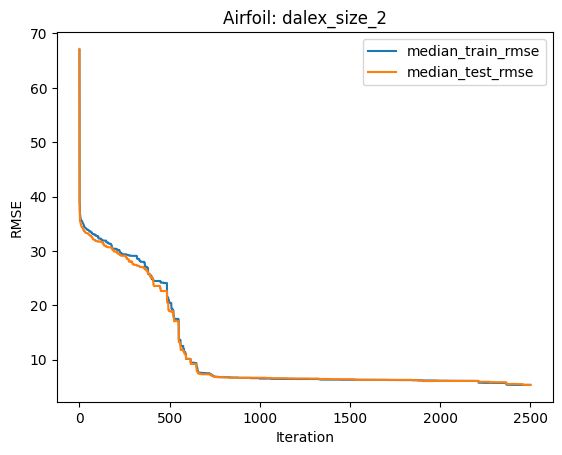

In [160]:
plt.plot(logs['median_train_rmse'], label='median_train_rmse')
plt.plot(logs['median_val_rmse'], label='median_test_rmse')
plt.legend()
plt.title('Airfoil: dalex_size_2')  
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.show()

In [53]:
tr_df = pd.read_parquet('test_results/boston/dalex_size_2_test_results1.parquet')
tr_df

,dataset_name,split_id,trial_id,seed,rmse_test,mae_test,r2_test,generalization_gap_%,total_nodes,depth,train_rmse,overfitting_%,time,latex_repr
0,boston,0,0,20,4.554407,3.532758,0.680861,7.745941,103,9,4.129402,-10.292166,105.051849,\begin{equation}- x_{12} + x_{3} + \frac{x_{3}...
1,boston,0,1,20,4.151466,3.160667,0.734833,1.786621,55,9,4.143259,-0.198100,87.337356,\begin{equation}\frac{0.2625 x_{10} \left(x_{6...
2,boston,0,2,20,3.870044,2.946167,0.769565,8.444381,93,9,3.561677,-8.657908,130.599323,\begin{equation}- \frac{0.15 x_{0} \left(2 x_{...
3,boston,0,3,20,4.910125,3.314939,0.629062,16.161345,91,9,4.305913,-14.032144,100.181542,\begin{equation}- \frac{x_{12}}{x_{5}} + \frac...
4,boston,0,4,20,4.575270,3.595489,0.677930,8.239511,87,9,4.167156,-9.793586,126.640211,\begin{equation}- x_{12} + \frac{2 x_{12}}{x_{...
5,boston,0,5,20,3.889695,3.017763,0.767219,7.979486,53,9,3.867251,-0.580364,162.409959,\begin{equation}\frac{x_{0} x_{3}}{x_{7}} - 0....
6,boston,0,6,20,3.886766,2.771407,0.767569,8.048780,111,9,3.630892,-7.047128,180.162874,\begin{equation}\frac{1.11111111111111 x_{5}^{...
7,boston,0,7,20,4.257592,3.336342,0.721103,0.724033,55,9,4.235678,-0.517358,111.659843,\begin{equation}\frac{6.66666666666667 x_{10} ...
8,boston,0,8,20,4.141154,3.208491,0.736149,2.030594,87,9,3.916041,-5.748490,121.646195,\begin{equation}x_{5} + \frac{20.0 x_{5} - 0.2...
9,boston,0,9,20,4.482806,3.591488,0.690816,6.052053,103,9,4.411774,-1.610059,100.805168,\begin{equation}\frac{x_{12}^{2}}{2 x_{5}^{2} ...
